In [10]:
import sys
import numpy as np 
from torch.utils.data import DataLoader 
from datasets.dataset_ensemble import EnsembleDataset 
from utils.ensemble import get_best_model_idx  
from utils.ensemble import get_weighed_ensemble_result
from utils.ensemble import porting_args
import matplotlib.pyplot as plt

In [2]:
def customcollatefn(sample):

    img, label = list(zip(*sample))

    img = np.array(img, dtype=np.float32)
    label = np.array(label, dtype=np.float32)

    return img, label

In [3]:
IMAGE_ROOT = '/opt/ml/input/data/train/DCM'
LABEL_ROOT = '/opt/ml/input/data/train/outputs_json'

config_path = './config.json'
args = porting_args(config_path)

dataset = EnsembleDataset(args, IMAGE_ROOT, LABEL_ROOT, fold_num=0, is_train=False)

data_loader = DataLoader(
        dataset=dataset, 
        batch_size=1,
        collate_fn = customcollatefn,
        shuffle=False,
        num_workers=8, # 8
        drop_last=True,
    )

In [4]:
image, label = next(iter(data_loader))
print(image.shape, label.shape)

(1, 3, 1024, 1024) (1, 29, 1024, 1024)


In [5]:
# fig, ax = plt.subplots(1, 2, figsize=(24, 12))
# ax[0].imshow(image.squeeze().transpose(1,2,0))    # remove channel dimension
# ax[1].imshow(label[0][0],cmap='gray')

In [6]:
# sys.path.insert(0, '/opt/ml/input/code/develop2/')
model_name = "exp_Unet_mit_1024_13"
model_paths = [
    f'checkpoint/{model_name}/best_model.pt' # for JH, os.path.join(args.savedir, args.exp_name+str(args.exp_num))
] 

best_model_idx_per_class = get_best_model_idx(model_paths, config_path, data_loader)

/opt/conda/envs/segmentation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 160/160 [02:39<00:00,  1.00it/s]


model 0:  [0.9462801, 0.96526754, 0.9736902, 0.9423932, 0.9568099, 0.96970356, 0.9681711, 0.94880056, 0.95930517, 0.9675921, 0.9627776, 0.9518455, 0.95743865, 0.9650925, 0.96195716, 0.93840265, 0.9515041, 0.96596897, 0.9686114, 0.9374298, 0.92010003, 0.9569911, 0.94323575, 0.9640789, 0.954107, 0.9480836, 0.9054731, 0.98555696, 0.9823952]


In [7]:
best_model_idx_per_class

array([[0.9462801 , 0.96526754, 0.9736902 , 0.9423932 , 0.9568099 ,
        0.96970356, 0.9681711 , 0.94880056, 0.95930517, 0.9675921 ,
        0.9627776 , 0.9518455 , 0.95743865, 0.9650925 , 0.96195716,
        0.93840265, 0.9515041 , 0.96596897, 0.9686114 , 0.9374298 ,
        0.92010003, 0.9569911 , 0.94323575, 0.9640789 , 0.954107  ,
        0.9480836 , 0.9054731 , 0.98555696, 0.9823952 ]], dtype=float32)

In [8]:
print(best_model_idx_per_class.shape)
print(best_model_idx_per_class)
np.savetxt(f"checkpoint/{model_name}/{model_name}.txt", best_model_idx_per_class, delimiter=",") #### edit save path ####
# temp = np.loadtxt("/opt/ml/output/best_model_idx_per_class.txt").astype(np.int32)
# print(temp.shape)
# print(temp)

(1, 29)
[[0.9462801  0.96526754 0.9736902  0.9423932  0.9568099  0.96970356
  0.9681711  0.94880056 0.95930517 0.9675921  0.9627776  0.9518455
  0.95743865 0.9650925  0.96195716 0.93840265 0.9515041  0.96596897
  0.9686114  0.9374298  0.92010003 0.9569911  0.94323575 0.9640789
  0.954107   0.9480836  0.9054731  0.98555696 0.9823952 ]]


In [9]:
# ensemble 할 csv 파일 경로
output_paths = [
    '/opt/ml/output/ouptut_HJH/output_202306201029.csv' #### 열람 경로 수정하기 ####
] 

save_path = '/opt/ml/temp/weighted_ensemble/weighted_ensemble_output_1.csv'  #### 저장 경로 수정하기 ####


# get_weighed_ensemble_result(output_paths, save_path, best_model_idx_per_class) 
get_weighed_ensemble_result(output_paths, save_path, best_model_idx_per_class, weight=2, thr=2)

FileNotFoundError: [Errno 2] No such file or directory: '/opt/ml/output/ouptut_HJH/output_202306201029.csv'

Text(0.5, 1.0, 'weighted_ensemble_output_1.csv')

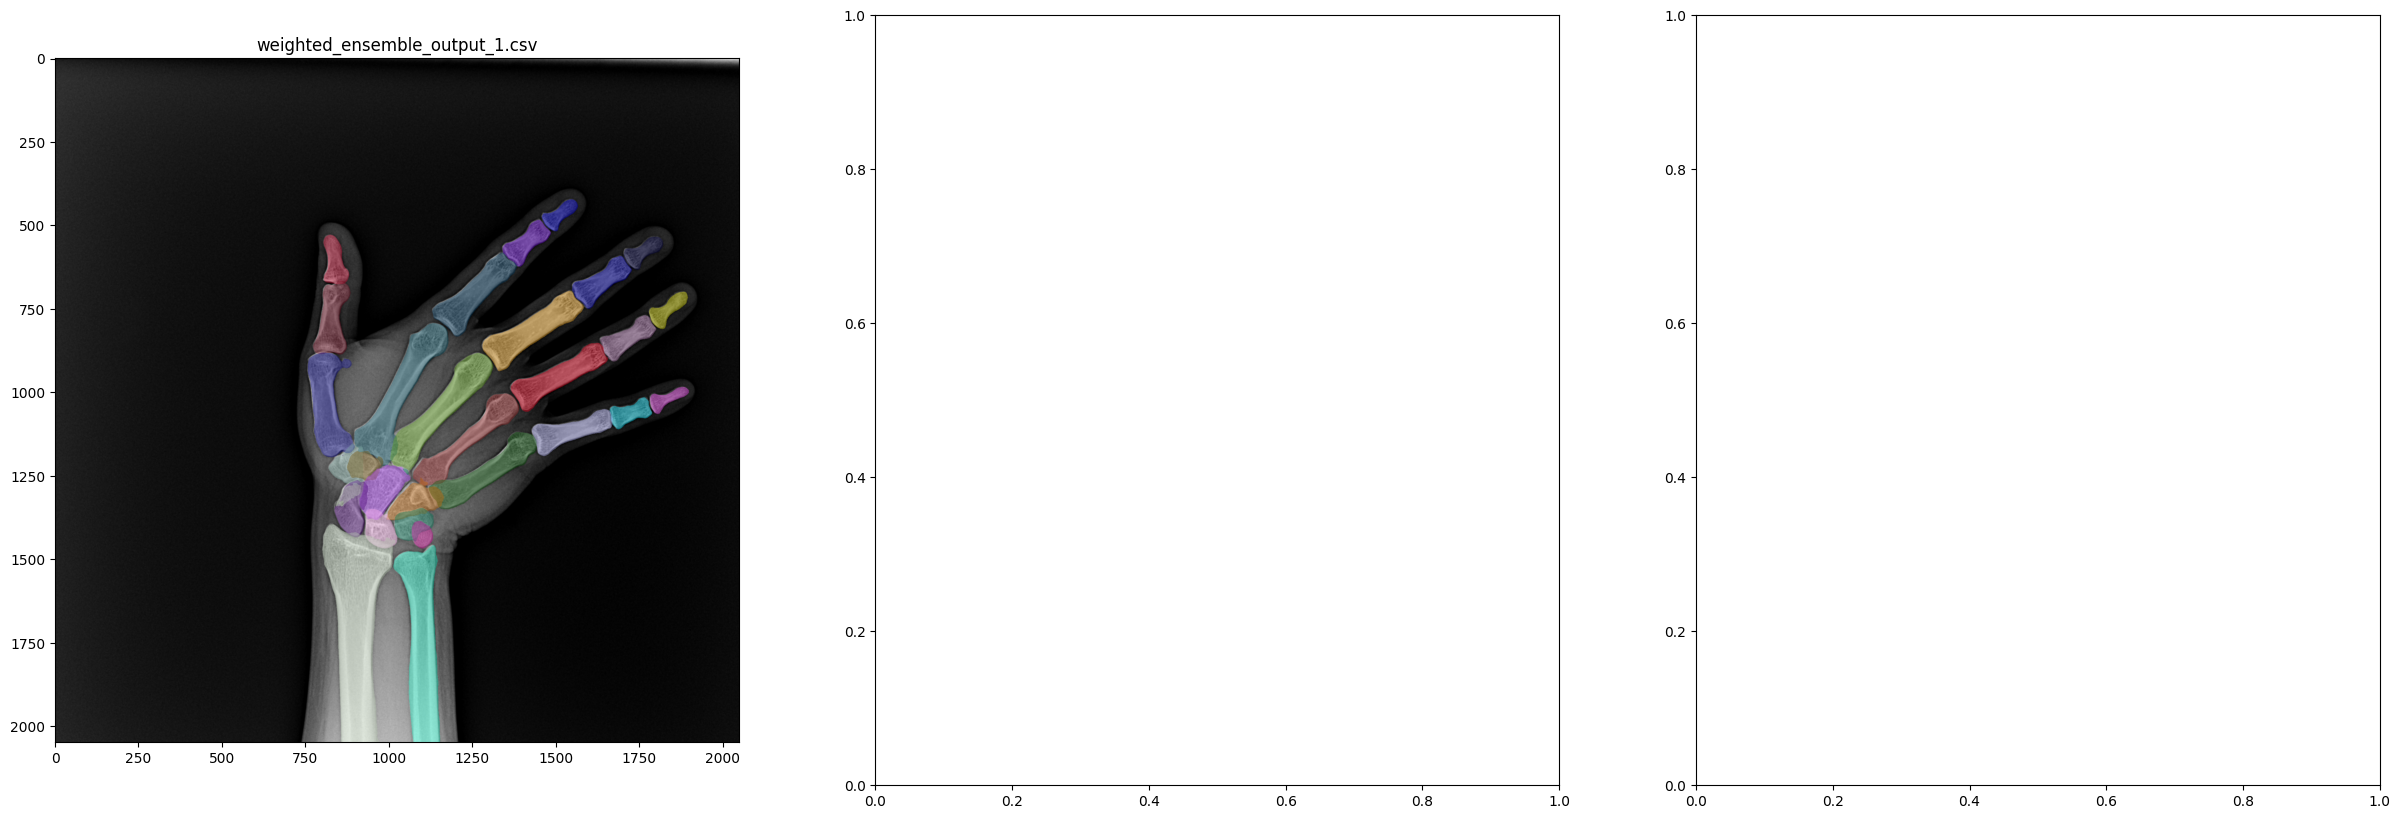

In [ ]:
from utils.vis import get_masked_image_from_csv 
from matplotlib import pyplot as plt 

image_path = '/opt/ml/input/data/test/DCM/ID255/image1663723504424.png'
csv_path1 = '/opt/ml/temp/weighted_ensemble/weighted_ensemble_output_1.csv'
# csv_path2 = '/opt/ml/ensemble_outputs/weighted_ensemble_output_2.csv'
# csv_path3 = '/opt/ml/input/code/saved_model/exp27_EfficientUNetpp_1024_aug1_customloss/epoch061_ouput.csv'

masked_image1 = get_masked_image_from_csv(image_path, csv_path1)
# masked_image2 = get_masked_image_from_csv(image_path, csv_path2)
# masked_image3 = get_masked_image_from_csv(image_path, csv_path3) 

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(masked_image1) 
ax[0].set_title('weighted_ensemble_output_1.csv')
# ax[1].imshow(masked_image2)
# ax[1].set_title('weighted_ensemble_output_1.csv') 
# ax[2].imshow(masked_image3)
# ax[2].set_title('exp27_EfficientUNetpp') 

Text(0.5, 1.0, 'weighted_ensemble_output_1.csv')

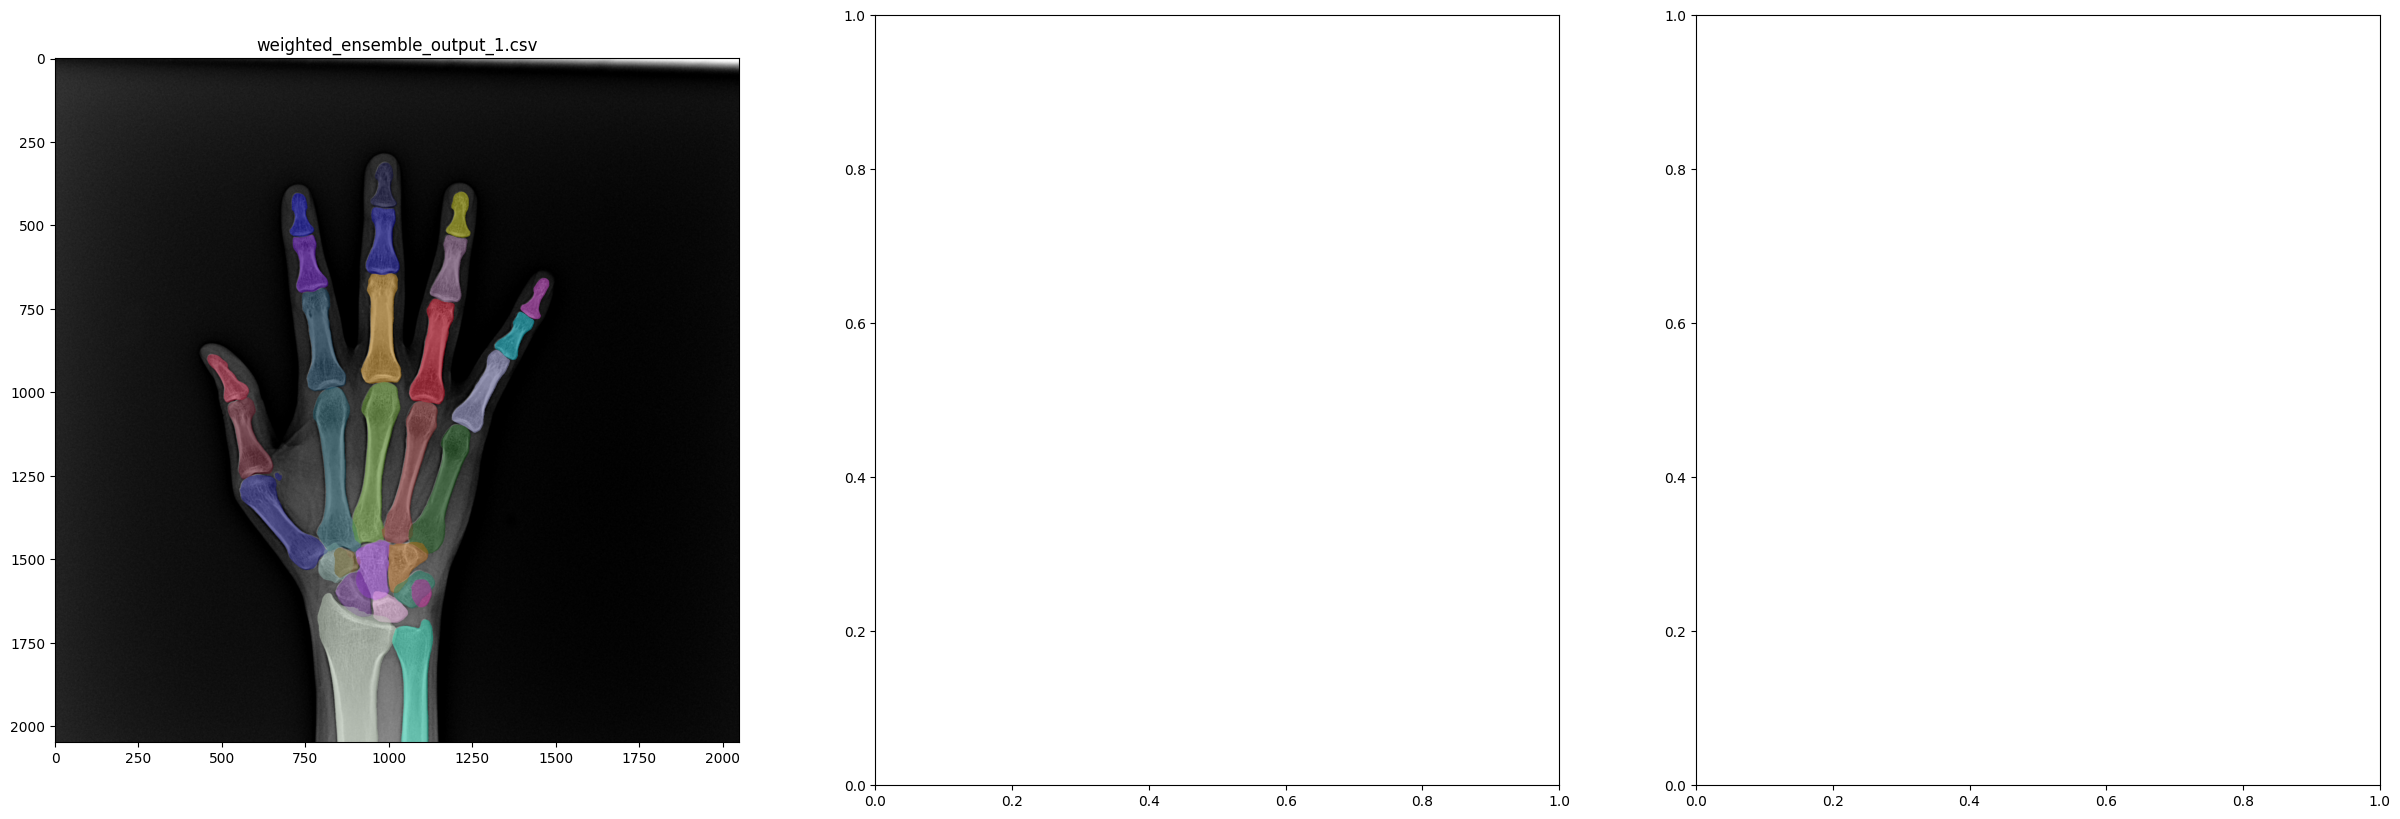

In [ ]:
image_path2 = '/opt/ml/input/data/test/DCM/ID040/image1661319116107.png' 

masked_image1 = get_masked_image_from_csv(image_path2, csv_path1)
# masked_image2 = get_masked_image_from_csv(image_path2, csv_path2)
# masked_image3 = get_masked_image_from_csv(image_path2, csv_path3) 

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(masked_image1) 
ax[0].set_title('weighted_ensemble_output_1.csv')
# ax[1].imshow(masked_image2)
# ax[1].set_title('weighted_ensemble_output_1.csv') 
# ax[2].imshow(masked_image3)
# ax[2].set_title('exp27_EfficientUNetpp') 